# Preprpcessing

In [46]:
# import transformers
# transformers.__version__

'4.30.2'

In [ ]:
#TODO

# Модель можно обучить и загрузить в mlflow.

# os.environ["MLFLOW_TRACKING_URI"]="http://172.16.7.61:5000/"
# os.environ["MLFLOW_EXPERIMENT_NAME"]="summarization_test4"
# os.environ["MLFLOW_FLATTEN_PARAMS"]="1" 
# os.environ["HF_MLFLOW_LOG_ARTIFACTS"]="1"

# но при этом невозможно выгрузть модель обратно как объект transformers
# назад возвращается объект Pyfunc.

# logged_model = 'runs:/e9193c917ea04a61bf6d2faa8bc19c49/checkpoint-7'
# model = mlflow.pyfunc.load_model(logged_model)

# если использовать для выгрузки метод библиотеки transformers:

# path = 'runs:/e9193c917ea04a61bf6d2faa8bc19c49/checkpoint-7'
# model = mlflow.transformers.load_model(path, return_type='components')

# то возвращается исключение вида: MlflowException: Model does not have the "transformers" flavor
# откат к более ранним версиям transformers ('4.30.2') также не приводит к изменениям.

In [22]:
import pandas as pd
import numpy as np
import os
import mlflow
from utils.mlflow_helpers import load_model_by_name
import evaluate
from pathlib import Path
from datasets import Dataset, DatasetDict, load_dataset

from transformers import AutoTokenizer
from transformers import DataCollatorForSeq2Seq
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import pipeline

from utils.operate_data import load_dataset as dd_load_dataset

from tqdm import tqdm
tqdm.pandas()

%matplotlib inline

In [23]:
df_meta, _ = dd_load_dataset('/local_data/meta_data/', df_name = 'meta.pickle', files_df_name=None)
df_meta.reset_index(inplace=True)
df_meta.rename(columns={'content': 'summary'}, inplace=True)

df_prepared = pd.read_pickle('/local_data/meta_data/prepared_files.pickle')
df_prepared = df_prepared[df_prepared.content.agg(len) != 0]
df_prepared = df_prepared[df_prepared.extension == '.pdf']
df_prepared = df_prepared.loc[df_prepared.groupby('doc_id')['order'].idxmax()]
df_prepared.rename(columns={'content': 'text'}, inplace=True)

df_content = df_prepared.merge(df_meta, on='doc_id')
df_content = df_content[['doc_id', 'text', 'summary']]

In [24]:
df_meta.shape, df_prepared.shape, df_content.shape

((9528, 30), (8058, 10), (8058, 3))

<Axes: >

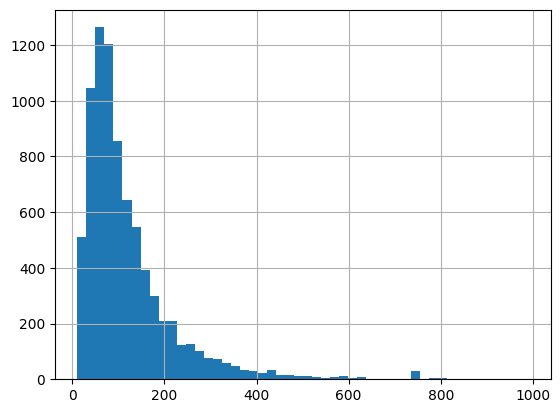

In [25]:
df_content.summary.agg(len).hist(bins=50)

# Train

##### создание небольшого датафрейма для быстрых эксперементов

In [26]:
dataset = DatasetDict({'train': Dataset.from_pandas(df_content[:50]),
                       'test': Dataset.from_pandas(df_content[8030:])})
dataset

DatasetDict({
    train: Dataset({
        features: ['doc_id', 'text', 'summary'],
        num_rows: 50
    })
    test: Dataset({
        features: ['doc_id', 'text', 'summary'],
        num_rows: 28
    })
})

#### создание полноценного датафрейма на основе всех данных

In [27]:
train_size = int(len(df_content)*0.85)
train_size

6849

In [28]:
# dataset = DatasetDict({'train': Dataset.from_pandas(df_content[:train_size]),
#                        'test': Dataset.from_pandas(df_content[train_size:])})

In [47]:
# load model from mlflow

# model = load_model_by_name('summarization')

# logged_model = 'ada94b4f37dd42768e4ec3358f956692'

# logged_model = 'runs:/e9193c917ea04a61bf6d2faa8bc19c49/checkpoint-7'
# model = mlflow.pyfunc.load_model(logged_model)

# model = mlflow.transformers.load_model(logged_model)

# path = 'runs:/e9193c917ea04a61bf6d2faa8bc19c49/checkpoint-7'
# model = mlflow.transformers.load_model(path, return_type='components')
# tokenizer = AutoTokenizer.from_pretrained('/local_data/summarization/data/csebuetnlp_mT5_m2o_russian_crossSum')

In [38]:
model = AutoModelForSeq2SeqLM.from_pretrained( '/local_data/summarization/models/csebuetnlp_mT5_m2o_russian_crossSum/')
tokenizer = AutoTokenizer.from_pretrained('/local_data/summarization/data/csebuetnlp_mT5_m2o_russian_crossSum')

In [39]:
prefix = "summarize: "

def preprocess_function(examples):
    inputs = [prefix + doc for doc in examples["text"]]
    model_inputs = tokenizer(inputs, max_length=1024, truncation=True)

    labels = tokenizer(text_target=examples["summary"], max_length=128, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [40]:
tokenized_dataset = dataset.map(preprocess_function, batched=True)
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

Map: 100%|██████████| 28/28 [00:00<00:00, 98.54 examples/s]


In [41]:
rouge = evaluate.load("rouge")

In [42]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

In [43]:
# os.environ["MLFLOW_TRACKING_URI"]="http://172.16.7.61:5000/"
# os.environ["MLFLOW_EXPERIMENT_NAME"]="summarization_test4"
# os.environ["MLFLOW_FLATTEN_PARAMS"]="1" 
# # os.environ["MLFLOW_NESTED_RUN"]="1"
# os.environ["HF_MLFLOW_LOG_ARTIFACTS"]="1"

In [44]:
training_args = Seq2SeqTrainingArguments(
    save_total_limit=1, # new
    load_best_model_at_end=True, #new
    output_dir="./",
    evaluation_strategy="epoch",
    save_strategy="epoch", # new
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    num_train_epochs=1,
    predict_with_generate=True,
#     use_cpu=True, # new
    #report_to='mlflow', # new
    fp16=False,
    push_to_hub=False,
    run_name='test_1'
    ) 

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# аргумент  в training_raits fp16=True - проблемы - работает только с куда
# возможное решение !pip install transformers==4.28.0
# или pip install accelerate -U

In [20]:
trainer.train()

2023/10/13 10:55:31 INFO mlflow.tracking.fluent: Experiment with name 'summarization_test4' does not exist. Creating a new experiment.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,No log,1.820712,0.056100,0.014300,0.056100,0.056100,24.392900


TrainOutput(global_step=7, training_loss=2.1117188589913503, metrics={'train_runtime': 262.58, 'train_samples_per_second': 0.19, 'train_steps_per_second': 0.027, 'total_flos': 119904613171200.0, 'train_loss': 2.1117188589913503, 'epoch': 1.0})

In [6]:
# SAVE MODEL AND TOKENIZER

# tokenizer.save_pretrained('/local_data/summarization/data/csebuetnlp_mT5_m2o_russian_crossSum')
# model.save_pretrained('/local_data/summarization/models/csebuetnlp_mT5_m2o_russian_crossSum/')

# LOAD MODEL AND TOKENIZER

# tokenizer = AutoTokenizer.from_pretrained('/local_data/summarization/data/csebuetnlp_mT5_m2o_russian_crossSum')
# model = AutoModelForSeq2SeqLM.from_pretrained('/local_data/summarization/models/csebuetnlp_mT5_m2o_russian_crossSum/')

In [21]:
mlflow.end_run()

## PREDICT

In [ ]:
# model = load_model_by_name('')

In [35]:
train_size = int(len(df_content)*0.85)
train_size

6849

In [36]:
df_test = df_content[train_size:]

df_test = df_test.tail(50)

In [24]:
# # Ранее работавший метод. Выявились ошибки во время суммаризации. При обработке массивных текстов (более 20 000 знаков)
# # умирает ядро. Решением проблемы является отказ от метода pipeline и передача в токенизатор напрямую параметров
# # max_length=1024, truncation=True. Видимо в методе pipeline такие параметры по умолчанию не предусмотренны, хотя  
# # и передаётся предобученный токенизатор с такими параметрами

# tokenizer_kwargs = {'truncation':True,'max_length':512}
# summarizer = pipeline("summarization", 
#                       tokenizer=AutoTokenizer.from_pretrained('/local_data/summarization/data/csebuetnlp_mT5_m2o_russian_crossSum', 
#                                                               **tokenizer_kwargs),
#                       model=AutoModelForSeq2SeqLM.from_pretrained('/local_data/summarization/models/csebuetnlp_mT5_m2o_russian_crossSum/'), 
#                       max_length=64)

# def get_summary(text: str, summarizer) -> str:
#     return summarizer(text)[0]['summary_text']

# def get_summary(text: str, summarizer) -> str:
#     tokenizer_kwargs = {'truncation':True,'max_length':1024}
#     return summarizer(text, **tokenizer_kwargs)[0]['summary_text']

# df_test['predict_summary'] = df_test['text'].progress_apply(lambda row: get_summary(row, summarizer))


In [25]:
def summarizer(text: str, tokenizer: AutoTokenizer, model = AutoModelForSeq2SeqLM) -> str:
    
    inputs = tokenizer(text, max_length=1024, truncation=True, return_tensors="pt").input_ids
    outputs = model.generate(inputs, max_new_tokens=200, do_sample=False)
    
    return tokenizer.decode(outputs[0], skip_special_tokens=True)
    

In [26]:
df_test['predict_summary'] = df_test['text'].progress_apply(lambda row: summarizer(row, tokenizer, model))

100%|██████████| 5/5 [00:12<00:00,  2.41s/it]


In [27]:
df_test[['summary', 'predict_summary']].head(10)

,summary,predict_summary
8053,О передаче земельных участков в государственну...,О направлении проекта уточнения проекта сооруж...
8054,О напралении информации по ротации членов Коми...,О просьбе определить кандидатуру вашего замест...
8055,О предоставлении ежеквартальной отчетности в р...,О направлении отчета ходе реализации проекта м...
8056,О согласовании проекта распоряжения Правительс...,О направлении информации по вопросу повторного...
8057,О направлении сведений о регистрации вещных пр...,О направлении сведений регистрации вещных прав...


In [28]:
def compare_summary_with_predict(number):
    print(f' TEXT: {df_test["text"].iloc[number]}\n')
    print(f' TRUE: {df_test["summary"].iloc[number]}\n')
    print(f' PREDICT: {df_test["predict_summary"].iloc[number]}')

In [29]:
compare_summary_with_predict(0)

 TEXT: лист1 б.№ о1_і l_j obi орг s=215ea перепад уточняется проектом ohcth-ьурум 90:0 wjjooop ѵшё дж'здыгёудул 90:00:000000:663 чёс-кош 13j9 s32 l=3360 уточняется проектом 90:25:0 21-342 90:25:000000:1648 jiirt 4.85га 3=14.2 экспликация зданий сооружений номер плане наименобание канатная дорога нижняя зона кластера администратибное здание касса стойка информации гостиница номероб апарт-отель номероб коттеджи домоб домоб 3=300 хостел номероб кемпинг палаток спа-комплекс клиника зона общестбенного питания спортибные площадки теннисных корта мини-гольф зона отдыха скейтпарк/белопарк детский городок веребочный парк родельбан детский разблекательный парк зона посадки парапланоб абтостоянка машино-мест хозяйстбенные постройки склад абк уточняется проектом техническая зона насосная станция очистные сооружения бктп уточняется проектом техническая зона пожарные резербуары-уточняется проектом веохняя зона кластеоа ресторан кемпинг палаток гюмпинг палаток ѵір-сферы сфер коттеджи домоб амфитеатр 

# RESEARCH

Если значение количества токенов превышает 1024, то токенизатор отсекает лишние токены.
Изучение соответствия 1024 токенов количеству слов и символов в тексте.

In [32]:
tokenizer_kwargs = {'truncation':True,'max_length':1024}
tokenizer = AutoTokenizer.from_pretrained('/local_data/summarization/data/csebuetnlp_mT5_m2o_russian_crossSum', 
                                         **tokenizer_kwargs)
model = AutoModelForSeq2SeqLM.from_pretrained( '/local_data/summarization/models/csebuetnlp_mT5_m2o_russian_crossSum/')

In [ ]:
#  max_length=1024, truncation=True,

In [37]:
df_truncated = pd.DataFrame(columns=(['doc_id', 'num_symbols', 'num_words', 'num_tokens', 'num_truncated_tokens', 
                                     'num_truncated_symbols', 'num_truncated_words']))
counter = 0
for ind, row in df_test.iterrows():
    counter += 1
    print(f'{counter}/{df_test.shape[0]}', end='\r')
    inputs = tokenizer(row.text, return_tensors="pt").input_ids 
    inputs_truncated = tokenizer(row.text, return_tensors="pt").input_ids
    truncated_text = tokenizer.decode(inputs_truncated[0], skip_special_tokens=True)
    df_truncated.loc[ind,:] = [row.doc_id, len(row.text), len(row.text.split(' ')), len(inputs[0]),
                               len(inputs_truncated[0]), len(truncated_text), len(truncated_text.split(' ')) ]
    

In [38]:
df_truncated

,doc_id,num_symbols,num_words,num_tokens,num_truncated_tokens,num_truncated_symbols,num_truncated_words
8008,fdf3e0aa-fee8-48ea-a66e-1cc869bbaa32,1498,146,372,372,1498,146
8009,fdf64419-b642-470d-bdad-a81b23118845,1198,128,322,322,1198,128
8010,fdf6df5b-5dbf-4784-874d-1ffcf9c7fa4f,763,82,206,206,763,82
8011,fdfb61e9-bbc5-4157-9949-7a61cefb5d50,1225,129,334,334,1227,129
8012,fdfc163c-e713-49d6-9ab6-4fecc3a16b33,26762,2670,6005,6005,26763,2670
8013,fe038b89-eaa8-47bb-bbfc-a4c544085509,1804,183,417,417,1806,183
8014,fe1f10bd-a31e-43bb-b0d5-bd6f0e43dcd8,4753,473,1141,1141,4754,473
8015,fe371576-27d3-4f96-88ed-b092ca3dcb73,2753,259,642,642,2754,259
8016,fe4a7ffe-2e09-4661-a66c-f936cead1521,1228,123,332,332,1228,123
8017,fe623eb3-1444-4077-9894-87c7cd232a75,2074,254,718,718,2078,254


In [85]:
df_1024 = df_truncated[df_truncated.num_truncated_tokens == 1024]
df_1024

,doc_id,num_symbols,num_words,num_tokens,num_truncated_tokens,num_truncated_symbols,num_truncated_words
7960,fc410826-a0c6-4614-a6a7-0888408c4c99,19220,1858,4620,1024,4019,406
7961,fc48e860-aa0b-4dda-ba3b-45ca40d5c1ff,23472,2380,5624,1024,4071,424
7965,fc62875b-1a0c-4a33-a5bb-54d9eeb55224,50623,5184,11471,1024,4706,451
7966,fc71d148-24eb-4b7f-92a0-f370fe6364b3,141712,15137,33138,1024,4370,448
7967,fc7949b5-51e8-4749-a256-274e0e1e822a,12876,1328,2912,1024,4442,450
7974,fd0d9867-f644-451d-bdbe-2f9886e36781,4720,487,1104,1024,4389,453
7979,fd3c5fa5-4515-4c7c-8142-8599f2848d75,4586,451,1094,1024,4377,431
7980,fd489127-f118-4872-90d9-d9f2f209c406,3908,394,1047,1024,3852,389
7981,fd502f03-1b70-4318-bba9-9fcfb7193e5f,18487,1816,4049,1024,4522,456
7982,fd55eca1-2790-4126-b6fb-9ba0748e0fb6,5744,561,1326,1024,4406,428


In [90]:
df_1024.num_truncated_symbols.min(), df_1024.num_truncated_symbols.max(), df_1024.num_truncated_symbols.mean()

(2008, 4785, 4171.083333333333)

In [91]:
df_1024.num_truncated_words.min(), df_1024.num_truncated_words.max(), df_1024.num_truncated_words.mean()

(268, 471, 421.8888888888889)

In [120]:
df_1024.num_truncated_symbols.min(), df_1024.num_truncated_symbols.max(), df_1024.num_truncated_symbols.mean()

(2012, 4789, 4175.083333333333)

In [121]:
df_1024.shape

(36, 7)